# Predicting Bouldering Route Difficulty with Fast.Ai, ResNet, and Image Classification

*Can I climb this wall? Well, fine-tuning a classification model on pictures of the wall is easy and powerful, but it's hard to trust the answers.*

John Mundahl, 2023.05.04

Cut to the chase: try this [hugging face demo](https://huggingface.co/spaces/mundahl/Bouldering_Moonboard_Classification_Fast.ai_Lecture2?logs=build). Then loop back to understand what it's about!

Fast.Ai's [Practical Deep Learning course](https://course.fast.ai/) launches into creating models. The instructor, Jeremy Howard, has you fine-tuning image classification models in the first lecture. Theory? Explanation? Understanding? No, no, no - overrated. Neural networks are magic! So why not get the learner addicted to the [magic](https://https://www.goodreads.com/quotes/14885-any-sufficiently-advanced-technology-is-indistinguishable-from-magic)? The best way to fuel an addiction is to befriend the source of this magic and even create your own source eventually! Jeremy and Fast.Ai do exactly this with their gradual explanation of Neural Network *source* code. 

But "gradual" is key. After the second lecture, he challenges you to [find your own problem](https://youtu.be/J6XcP4JOHmk?t=2269) that deep learning might help solve, then do it! Err.. at least do it with super-basic image classification because that's all we've learned. I brainstormed work and fun ideas, and while bouldering with friends, I landed on [bouldering](https://i.pinimg.com/originals/99/86/9b/99869b8fad090e3dc1e8fe275c97a47b.jpg)!


### Bouldering Basics
People try to climb up a potentially-tilted wall by grabbing and stepping onto multiple blobs ("*holds*") that are drilled into the wall. The holds vary much in size, shape, grippiness and more. Fewer, smaller, ~down-facing, and less-grippy holds make climbing up harder! But how much harder? Well, sets of holds ("*route*") are usually separated in some way - like via colors, so maybe you can **only** use the blue holds on the wall to get to the top. With separate colors, you can have separate difficulty levels! So if the holds are fewer/smaller/etc, they might be the blue difficulty and I wouldn't have a chance at climbing that route!

I can climb most orange and some black routes, but not all of them. So which of these routes are at the edge of my skill level and deserve a disproportionate amount of my time? Currently, I don't know until I try! And even then, I don't *fully* know until I either reach the top or I get stuck long enough that they take the route down.. But who has time for that?

Instead, I want to point a service at the climbing wall and have it estimate if the route is too hot, too cold, or just right. With the infinite combinations of holds, a solid solution may be the [infinitely configurable](https://en.wikipedia.org/wiki/Universal_approximation_theorem) neural network! Images provide a high-fidelity input vector, so our super-basic image classification model work seems like a useful starting point. 

### Distilling The Problem

While looking at a route, I considered how a neural network might assess difficulty. Maybe they'd need multiple angles for depth estimation? Maybe that funky NeRF concept is relevant? Would I need to specify the color of the route? Would the ~60 route up at my gym provide enough training data? Could I also source images online? How sensitive would the model be to angles, lighting, image quality and visual variations of the same route? Am I in too deep?

No! A neural net might be able to handle all of these, but to create (read: discover?) a great model, [being able to iterate is key](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/). In addition to iteration, I've seen discovery improved in [clinical](https://venousnews.com/contemporary-venous-intervention-reduces-pts-in-clear-dvt-analysis/) [and](https://www.clinicaltrials.gov/ct2/show/NCT03901872) [biomedical](https://ieeexplore.ieee.org/abstract/document/7590999?casa_token=BnF0NzwTGkoAAAAA:_l6LErPzjNZWnU6aWToX3878y8tW4U-mmfvp0lDopSY7m3cpX349IseOUElU9oaPLnWE96gpdUo) [research](https://www.sciencedirect.com/science/article/pii/S2213158216302613) by reducing variables to add more control. It's early in my Deep Learning journey, so I sought to reduce variables too. And boy did I find a good answer: MoonBoards. 

[Moonboards](https://www.flashed.com/explore/article/moonboard/) are to bouldering as [Go](https://towardsdatascience.com/alphago-how-ai-mastered-the-game-of-go-b1355937c98d) is to [Startcraft II](https://www.vox.com/future-perfect/2019/1/24/18196177/ai-artificial-intelligence-google-deepmind-starcraft-game): regimented and static topology, yet millions+ of combinations. For the moonboard, that's embodied by a large rectangular climbing surface with the ~same 187 holds at the same coordinates in each gym. Users can select one of many pre-designed routes in [their app](https://www.moonboard.com/moonboard-app), which will light up the physical holds that can be touched. The route designer and users can gradually assess the difficulty ranging from "5+" to "7A" to "8B+". And best yet, the app renders the entire MoonBoard wall with illustrations showing which holds are in play. So instead of 100-1000s of photos of climbing walls from different angles, I can start with screenshots of these battle-test MoonBoard routes!

### Data Pipeline
The app shows the board, in-play holds, and difficulty label on the same screen. So I took ~400 screenshots and put them in a directory. To get the label from each screenshot, I wrote and tuned in the following code.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


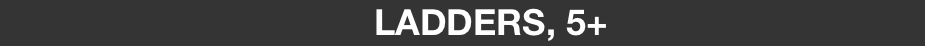

In [ ]:
from PIL import Image

def crop_image(image_path, rowA, rowB, colL=None, colR=None):
    """
    Crops an image to keep only the rows from rowA to rowB (inclusive),
    and optionally crops columns from the left and right edges of the image.

    Parameters:
    image_path (str): Path to the image file.
    rowA (int): Index of the first row to keep.
    rowB (int): Index of the last row to keep.
    colL (int): Number of columns to crop from the left edge of the image (default None).
    colR (int): Number of columns to crop from the right edge of the image (default None).

    Returns:
    PIL.Image: A cropped version of the input image.
    """
    with Image.open(image_path) as img:
        # Get the dimensions of the input image
        width, height = img.size

        # Determine the left and right bounds of the cropped image
        left = colL if colL else 0
        right = width - colR if colR else width

        # Crop the image to keep only the rows from rowA to rowB and optionally
        # crop columns from the left and right edges of the image
        cropped_img = img.crop((left, rowA, right, rowB + 1))

    return cropped_img

# My image_file variable commented out, a temp online photo added instead
#image_file = "/Users/johnmundahl/Documents/Work/Learn/MachineLearning/Fast.ai_DL1/Lesson2/Deploy/fastai_DL1_lecture2_climbing/imgs/IMG_1844.PNG"


# Temporary way to source the photo online
!pip install urllib3
from urllib.request import urlopen
import io
fd = urlopen("https://i.imgur.com/MU6FAOJ.png")
image_file = io.BytesIO(fd.read())


cropped_image = crop_image(image_file, 180, 225, 100, 100)
cropped_image

Which isolates the pixels for the route title and grade as such:
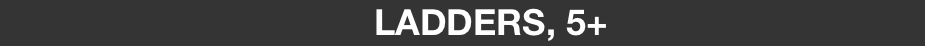
Then, I use Google's Tesseract to perform optical character recognition (OCR) and assign the title and difficulty ("grade") to separate variables.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!tesseract --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (31.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [ ]:
import pytesseract

def ocr_image(img):
    """
    Performs optical character recognition (OCR) on an input image and
    returns the resulting text as a string.

    Parameters:
    img (PIL.Image): The input image as a PIL image variable.

    Returns:
    str: The resulting OCR text.
    """
    # Convert the input image to grayscale
    img = img.convert("L")

    # Perform OCR using pytesseract
    text = pytesseract.image_to_string(img)

    return text

def process_string(input_string):
    """
    Splits the input string at each ", ", takes the last substring after the split,
    removes any "\n", and returns the resulting string.

    Parameters:
    input_string (str): The input string to be processed.

    Returns:
    str: The resulting processed string.
    """
    # String to split the input by
    splitting_string = ", "
    
    # Split the input string at each ", "
    substrings = input_string.split(splitting_string)

    # Take the last substring after the split
    last_substring = substrings[-1]

    # Remove any "\n" from the last substring
    processed_string = last_substring.replace("\n", "")
    
    # Take the first substring after the split
    title_substring = splitting_string.join(substrings[:-1])
    
    # Remove any "/" from the substring
    title_substring = title_substring.replace("/", "--")
    title_substring = title_substring.replace("\\", "--")

    # Remove any "\n" from the last substring
    processed_string = last_substring.replace("\n", "")

    return processed_string, title_substring

ocr_title_and_grade = ocr_image(cropped_image)
ocr_grade, ocr_title = process_string(ocr_title_and_grade)
ocr_grade, ocr_title

('5+\x0c', 'LADDERS')

Ideally, the OCR outputs ('5+', 'LADDERS'). Some pytesseract installs can add characters. My MacOS install never made weird characters, so all that was left was to save a cropped and compressed version of the file with the title and difficulty in the name. I didn't have great intuition around how downsizing the route image would impact model performance, so I saved three sets of every screenshot: 100 pixels wide, 300, and 1000! One criteria to iterate upon. 



In [ ]:
from PIL import Image

def resize_image(img, width_out):
    """
    Resizes the input image so that the width is equal to the specified output width
    and the length is scaled proportionally to the width.

    Parameters:
    img (PIL.Image.Image): The input image to be resized.
    width_out (int): The desired output width in pixels.

    Returns:
    PIL.Image.Image: The resized image.
    """
    # Get the original width and height of the image
    width_in, height_in = img.size

    # Calculate the scaling factor to resize the width to the desired output width
    scale_factor = width_out / width_in

    # Calculate the new height based on the scaling factor
    height_out = int(height_in * scale_factor)

    # Resize the image using the calculated width and height
    resized_img = img.resize((width_out, height_out), Image.ANTIALIAS)

    return resized_img

import glob

# Specify the folder path containing the PNG files
''' # My png_files variable commented out, a temp online photo set added instead
folder_path = "/Users/johnmundahl/Documents/Work/Learn/MachineLearning/Fast.ai_DL1/Lesson2/Deploy/fastai_DL1_lecture2_climbing/imgs"

# Use the glob module to get a list of all the PNG files in the folder
png_files = glob.glob(folder_path + "/*.PNG")
'''

# Temporary way to source the photo online
!pip install urllib3
from urllib.request import urlopen
import io
URLS = ["https://i.imgur.com/MU6FAOJ.png", "https://i.imgur.com/UNEfLYh.png",
        "https://i.imgur.com/xLnsNFF.png", "https://i.imgur.com/IqHOT8o.png"]
png_files = []
for url in URLS:
  fd = urlopen(url)
  png_file = io.BytesIO(fd.read())
  png_files.append(png_file)

import os
widths = [100, 300, 1000]
for width in widths:
  # folder_name is the name of the directory you want to create
  folder_name = "processed_" + str(width)

  # Check if the directory exists
  if not os.path.exists(folder_name):
    # If the directory does not exist, create it
    os.mkdir(folder_name)

all_grades = []
list_grades = []
list_titles = []

# Iterate over the list of PNG files
for png_file in png_files:
    # Process the PNG file here
    cropped_image = crop_image(png_file, 180, 225, 100, 100)
    ocr_title_and_grade = ocr_image(cropped_image)
    ocr_grade, ocr_title = process_string(ocr_title_and_grade)
    list_grades.append(ocr_grade)
    list_titles.append(ocr_title)
    cropped_route = crop_image(png_file, 260, 2100, 0, 0)
    for width in widths:
      resized_route = resize_image(cropped_route, width)
      image_name = "processed_" + str(width) + "/" + ocr_title + "__" + ocr_grade + ".jpg"
      resized_route.save(image_name)
    if ocr_grade not in all_grades:
        all_grades.append(ocr_grade)
    

import collections
counts = collections.Counter(list_grades)

for item, count in counts.items():
    print(f"{item}: {count}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
5+: 1
8B+: 1
6B: 1
6A: 1


Play our cards right and hook up all ~400 screenshots into the image list (which I do locally, not in Google Colab), and we'll end with three folders that each have all of the photos saved with title and difficulty labels in three different sizes! Refresh your "Files" area in the left panel of this page if you're executing along with me in Google Colab.

## Training the Model***s***
Since Google Colab currently offers some GPU compute for free, I opted to perform the rest of this notebook in Google Colab! 

Skipping ahead, [here's the model working](https://huggingface.co/spaces/mundahl/Bouldering_Moonboard_Classification_Fast.ai_Lecture2?logs=build) with example data and whatever you input!

#### An Aside About Detail
Cal Newport loves comedian Steve Martin's memoir ["Born Standing Up"](https://en.wikipedia.org/wiki/Born_Standing_Up) because Steve discusses so many of the [nitty gritty details](https://calnewport.com/the-steve-martin-method-a-master-comedians-advice-for-becoming-famous/) behind his breaks and lurches to eventual comedian stardom. Other successes gloss over the details of how they made it, but Steve shares who he talked to, what they discussed, and how that led to tons of mini breaks (and how he experimented in those opportunities!). 

These details allow others to understand where this often is and often isn't special sauce, what can be hard work, and what can be luck and persistence. It's all there! This is exactly why I love watching long-form videos of professionals working in their craft. The professional either thinks many of their details are boring or they're so second nature that they seem trivial or are unconscious! I want to know where others take non-obvious shortcuts and where they take non-obvious care.

For python coding, jupyter notebooks, like Google Colab, catalog so much of this detail. GitHub is the same! I can download *your* code, run each piece, play with different constructs, and understand how great code can work. I love it. There's at least one more layer of helpfulness: writing up how these programs came to be. I'm far from a deep learning success, but I'd be honored to unblock or accelerate the learning for someone who just finished the second lecture, but hasn't created their own model. Or heck, maybe you're reading this and find this useful for other reasons!

Either way, there's going to be some more detail than the average reader wants because 1) it's helpful and 2) it takes more time to write less :)

#### ^End Aside About Detail

So, training those models... I could have started with Professor Jeremy Howard's example code for creating our image classifier model, but I found TA [Tanishq Abraham's tutorial code](https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial) (that Jeremy references in the lecture) to be a bit more palatable. Tanishq had:

In [ ]:
## HEY! No need to run this cell. It's just an example!

from fastai.vision.all import *
path = untar_data(URLs.PETS)
dls = ImageDataLoaders.from_name_re(path, get_image_files(path/'images'), pat='(.+)_\d+.jpg', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75))
learn = vision_learner(dls, models.resnet50, metrics=accuracy)
learn.fine_tune(1)
learn.path = Path('.')
learn.export()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.3MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.933196,0.314676,0.903924,01:39


epoch,train_loss,valid_loss,accuracy,time
0,0.437760,0.236697,0.920839,01:38


I needed to tweak this to my situation. At a minimum, I knew the 'path' needed to point to my photos. I loaded my folders of processed photos into Colab (and eventually my google drive so the folders didn't keep getting deleted). I googled around and determined that 'path' could simply be a 'Path()' construct that contained a string to the folder in Google Colab's system: 

```
path = Path("/content/processed_100/")
```

Labels are important, but it wasn't obvious to me how Tanishq's code was getting label info for the pictures. I figured I needed to roll my own method since I didn't follow either label method from fast.ai's lectures thus far. Instead of *my* own method, I actually inquired if ChatGPT could source working code! And oh it did:



In [ ]:
# Define the path to the folder containing the images
path = Path("/content/processed_100/")

# Define a function to extract the label from the filename
def label_func(fname):
    return str(fname).split("__")[-1].split(".")[0]

# Create a DataLoaders object
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224),
                                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                   label_func=label_func)

ChatGPT created a function to determine the label based on my file name system *and* fed that into the DataLoader construct! ChatGPT also cut some DataLoaders parameters and added some. I ripped out the item and batch transforms because I was controlling downscaling the photos, screenshots don't need augmentation, and normalizing didn't seem necessary (but maybe it's helpful, not sure). Also inputing a files object into the DataLoader seemed more ~reliable than the path, so I did so. 

I added code from [Tanishq's tutorial](https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial) for inference/prediction from a given image. I ran this a few times (with my local dataset - sorry for those running the notebook along with me) and predictions and confidences were mediocre - ~25% accuracy - but reasonable!

In [ ]:
# Define the path to the folder containing the images
path = Path("/content/processed_100/")

# Define a function to extract the label from the filename
def label_func(fname):
    return str(fname).split("__")[-1].split(".")[0]

# Get a list of all image files in the folder
files = get_image_files(path)

# Create a DataLoaders object
dls = ImageDataLoaders.from_folder(path, files, valid_pct=0.2, seed=42, label_func=label_func)

# Define learner variable, fine tune with 1 epoch, and define the path
learn = vision_learner(dls, models.resnet50, metrics=accuracy)
learn.fine_tune(1)
learn.path = Path('.')

# Prediciton/Inference from Tanishq's tutorial
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

# Prediction example. In reality I did it in Gradio + HF Spaces, but I'm going to gloss over that..
predict(files[0])

I was thrilled to have a working training pipeline! I wasn't thrilled with ~25% success for a dozen categories. It was time to start iterating! I listed the high level parameters (hyperparameters?) that likely influenced the success of the model: 

1. Which pre-trained model? ResNet50 is one of five sibling models.
2. Fine-tune epochs. Tanishq used 1, but why not 3? 10? 30?? 100??? 
3. Photo resolution. I saved photos in 100, 300, and 1000 pixel widths!

What combination would work best? I had no clue! But I know how to make nested for-loops to try every combination and thus brute force the answer based on the training loss, validation loss, and accuracy. ChatGPT helped me churn out the following code:

In [ ]:
# Import google drive linking (you might need to pip install these)
from google.colab import drive
import os
import shutil

# Import fast.ai package
from fastai.vision.all import *

# Link to google drive. This will create a popup and 
# your drive would need to have the "pic_folder_paths" path with all of the photos
# I haven't exactly empowered you to make this happen. 
# In future posts, I want to learn how to upload a full dataset, so you can access these easier

# Define the paths to sets of pictures to try
pic_folder_paths = ["/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_100",
                    "/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_300",
                    "/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_1000"]

# Define the models to try
models_list = [models.resnet18, models.resnet34, models.resnet50, models.resnet101, models.resnet152]

# Define the number of epochs to try
num_epochs = [1, 3, 10, 30, 100]

# Create a variable to hold the output information
logger = [[[[0, 0, 0] for i in range(len(num_epochs))] 
           for j in range(len(models_list))] 
           for k in range(len(pic_folder_paths))]

# Define a function to extract the label from the filename
def label_func(fname):
    grade = str(fname).split("__")[-1].split(".")[0]
    return grade

# Define counters for the three loops
p_c = -1

# Iterate over all pictures
for p in pic_folder_paths:
  
  # Add to the p counter
  p_c += 1

  # Define the path to the folder containing the images
  path = Path(p)

  # Get a list of all image files in the folder
  files = get_image_files(path)

  # Create a DataLoaders object
  dls = ImageDataLoaders.from_name_func(path, files, valid_pct=0.2, seed=42, 
                                   label_func=label_func)

  # Define counters for the three loops
  m_c = -1
  
  # Iterate over all models
  for m in models_list:

    # Add to the p counter
    m_c += 1
  
    # Define the model
    learn = vision_learner(dls, m, metrics=accuracy)

    # Define counters for the three loops
    n_c = -1
  
    # Iterate over all epoch values to try
    for n in num_epochs:

      # Add to the p counter
      n_c += 1
    
      # Fine Tune the Model
      learn.fine_tune(n)

      # Log the data resulting from the runs (training loss, validation loss, and accuracy)
      logger[p_c][m_c][n_c] = [learn.final_record[0], 
                               learn.final_record[1], 
                               learn.final_record[2]]
      
      # TEMPORARY: Print the logger
      print(logger)

Sweet relief: It also worked the first try! The intermediate results were displaying in the notebook and I let it run overnight. I slept great. Meanwhile, my code eventually stopped running..

The stopped code explanation was simple: Google Colab times out after 1.5-4 hours and stops the runtime. Understandable! I saved my results for the ~third of combinations that were complete, tweaked the looped variables to skip these combinations, and ran the code again.

## Hello VRAM Darkness, My New Friend

I architected my looped variables to start with combinations of the ~smallest values - e.g. 100 pixel width, resnet18, and 1 epoch. So it didn't surprise me that the fine-tuning duration kept climbing until each epoch passed 30 seconds and climbing. But then the gears ground to a halt: 

```
OutOfMemoryError: CUDA out of memory. 
Tried to allocate 6.24 GiB (GPU 0; 14.75 GiB total capacity; 8.12 GiB already allocated; 5.29 GiB free; 8.38 GiB reserved in total by PyTorch) 

If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  
See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
```

Something about the fine-tuning was too large for the [VRAM](https://www.youtube.com/watch?v=wIMSU8otS-g) of the NVIDIA (?) chip Google was running on Colab session on! Whoa whoa whoa, I don't even know what fine-tuning really is. Am I supposed to understand the memory allocation nuances of my models and high level parameters?? Ultimately, "no", but it feels cool to already encounter a problem that the Open Source Software model community (and surely the private ones)deals with frequently!

So what did I do? I googled around for a feedback loop and a band aid solution. 

Feedback Loop:
```
!nvidia-smi
```
This allows me to see sweet, high level stats about the performance of the NVIDIA chip hosting my session.

Band Aid:
```
!kill 0
```
This simply resets the NVIDIA chip, which clears the memory. With a fresh memory, my current model doesn't have to compete with anything else that had hunkered down in the 'VRAM'. However, I had a feeling some of my fine-tuning arrangements might be too big for the NVIDIA chip. I set the fine-tuning to the largest combination: 1000 pixel width, resnet152, 100 epochs!

```
OutOfMemoryError: CUDA out of memory. 
```
Ahh yes, you again. Stack Overflow suggested allocating fewer bytes at once would help. 
```
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100"
```
This code maybe helped, or maybe it just took baby steps to the same memory wall. No big improvements. Next up, someone online suggested I tune the "batch size" to something smaller. I sorted out that meant adding a parameter to our DataLoader variable as "bs=#". I didn't know what the default was, so I started at something arbitrary: bs=32. The model still didn't run. I lowered the number until I determined bs=2 was seemingly the smallest option and the model just barely ran!

I ran the remaining combinations with bs=2. Check the appendix for *Final Training to Create Results* to see the code I ultimately used to get my loss and accuracy results.

## How and What Can We Learn?

To visualize the results ChatGPT and I, plotted the following. See the appendix for *Visualizing the Results* for the code used to generate these. For each fine-tuning, I had the training loss, validation loss, and accuracy numbers from the best performing epoch. I plotted one rectangle per number and had the number define the hue and shade.

For the fine-tuning with 300 pixel wide MoonBoards, ResNet50, and 10 epochs:


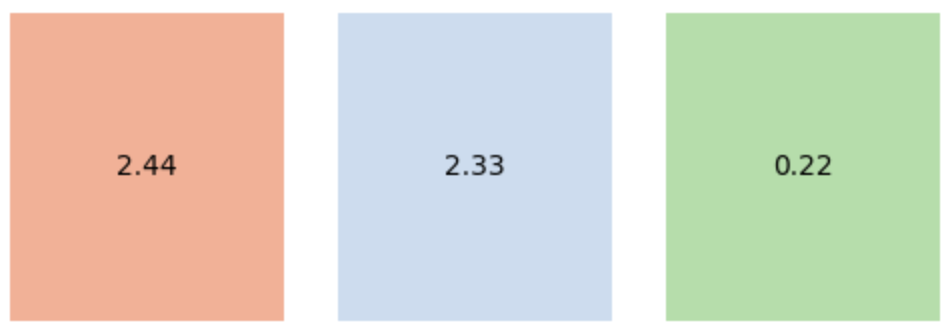

Of the three model variables - image resolution, pre-trained model size, and epochs - I wasn't sure what would create the lowest loss and highest accuracy. So I plotted these values across each range.

Comparing 1 epoch vs 3, 10, 30, and 100 (for 300 pixel images, and ResNet50):

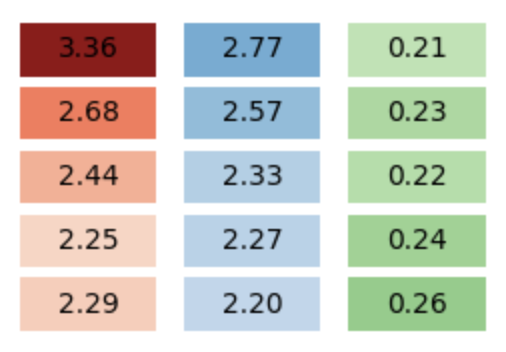



Training and validation loss (red and blue) do go down over time and accuracy (green) goes up as hoped! However, I don't have good intuition around if the magnitude of improvement is big or negligible. Accuracy of ~25% doesn't seem great when the lecture and textbook examples were getting 90%+ accuracy, which fewer classes admittedly. 

Then I compared ResNet18 vs 34, 50, 101, 152 (for 300 pixel images, 10 epochs):

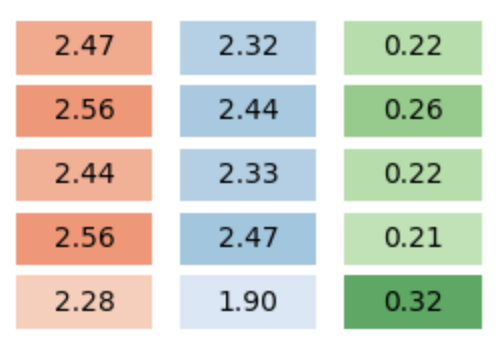

Welp, if you squint, I think you can argue that the larger pre-trained models *trend toward* better loss and accuracy numbers. But if it exists, it isn't obvious to me and isn't consistent across each model step. 

Truthfully, I don't know what I can learn from this. Maybe my ~400 images of MoonBoard routes isn't a large enough dataset to meaningfully separate the classification performance of these pre-trained models. Maybe all of these pre-trained models are overkill or underkill for this problem and I'd benefit from exploring a greater range. Maybe my fine-tuning paradigm isn't terribly effective. 

Next, I compared using images that were 100 pixels wide vs 300 and 1000 (for ResNet50, 10 epochs):

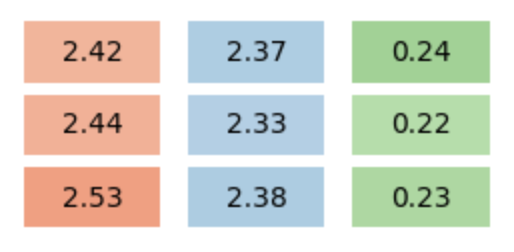

Interesting! Even though the total number of pixels goes up a magnitude each time, the performance is pretty constant. Maybe the training paradigm isn't constructed well to separate the resolutions, or maybe the tiny 100 pixel-wide images carry essentially as much useful information as the other two!

The previous grids were just one training run, but I have plenty more data, so I can average across the metrics! That's shown below.

Grid 1: Comparing 1 epoch vs 3, 10, 30, and 100, averaged across all image model sizes and resolutions.

Grid 2: Comparing ResNet 18 vs 34, 50, 101, and 152, averaged across everything else. 

Grid 3: Comparing 100 pixel width images vs 300 and 100, averaged across everything else. 

Red = Training Loss   |   Blue = Validation Loss   |   Green = Accuracy

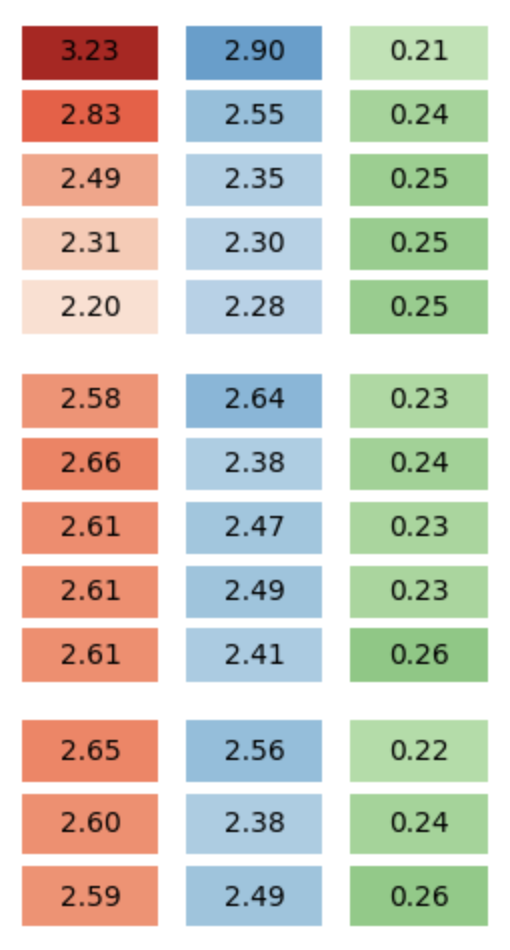

One of these grids is not like the other two! Fine-tuning on more epochs robustly improves performance in this paradigm, while model complexity and image resolution seem to currently have zero or minimal impact. 

Now, I'm aware of over-fitting, where the training forces the model to essentially memorize the training data. I don't have great intuition around when overfitting ramps up, but it seems it might increase as the fine-tuning epochs increase. Maybe the validation loss is informative! In Grid 1, the validation loss only decreases 1-2% between 10, 30, and 100 epochs, while the training loss decreases 3-5%. Maybe this isn't a fair comparison. If it is fair, then beyond 10 epochs this greater drop in training loss might just be memorizing/over-fitting!

## Curious Trends

#### Validation Loss Spikes

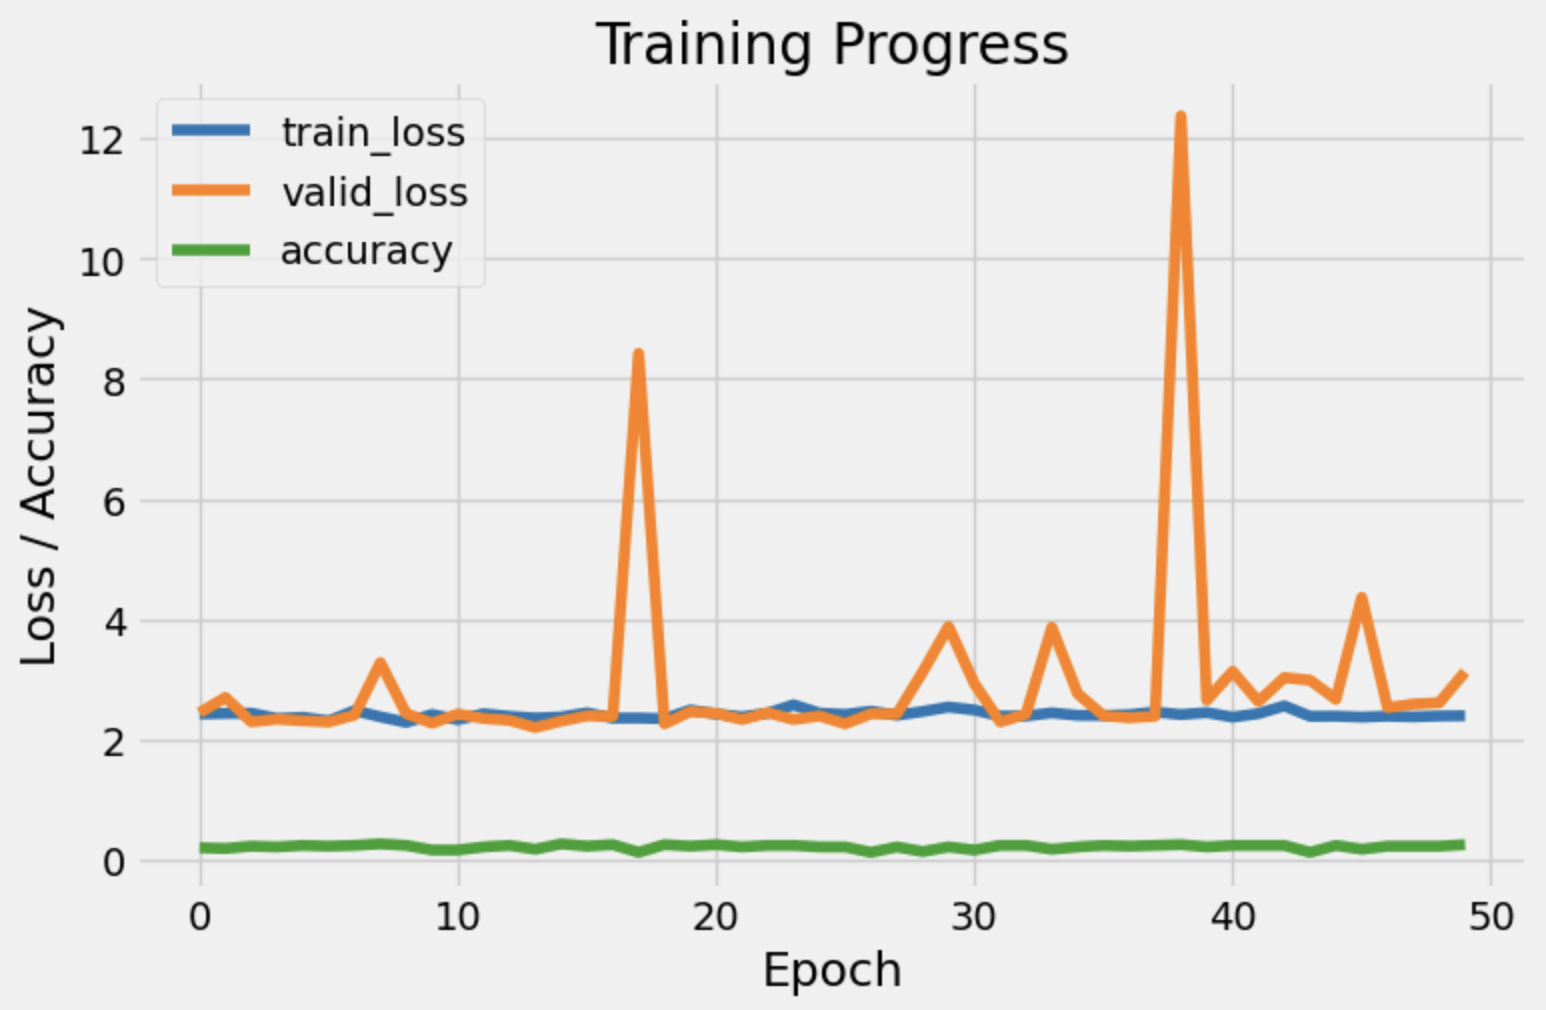

Here are the performance metrics for the first 50 epochs when training with 100 pixel-width images and the largest model: ResNet152. Ideally, you'd see training and validation loss jittering, but gradually coming down. Instead, we see validation spiking 30-300%! Truthfully, I don't know enough about fine-tuning and these metrics to decipher exactly what's happening. I'm guessing this is another over-fitting phenomenon: the fine-tuning drifts too close to the training data and too far from the validation in some wildly non-linear way. 

Crazy enough, 30-300% spikes are child's play. When 1000 pixel-width images are used, the spikes can go stratospheric!


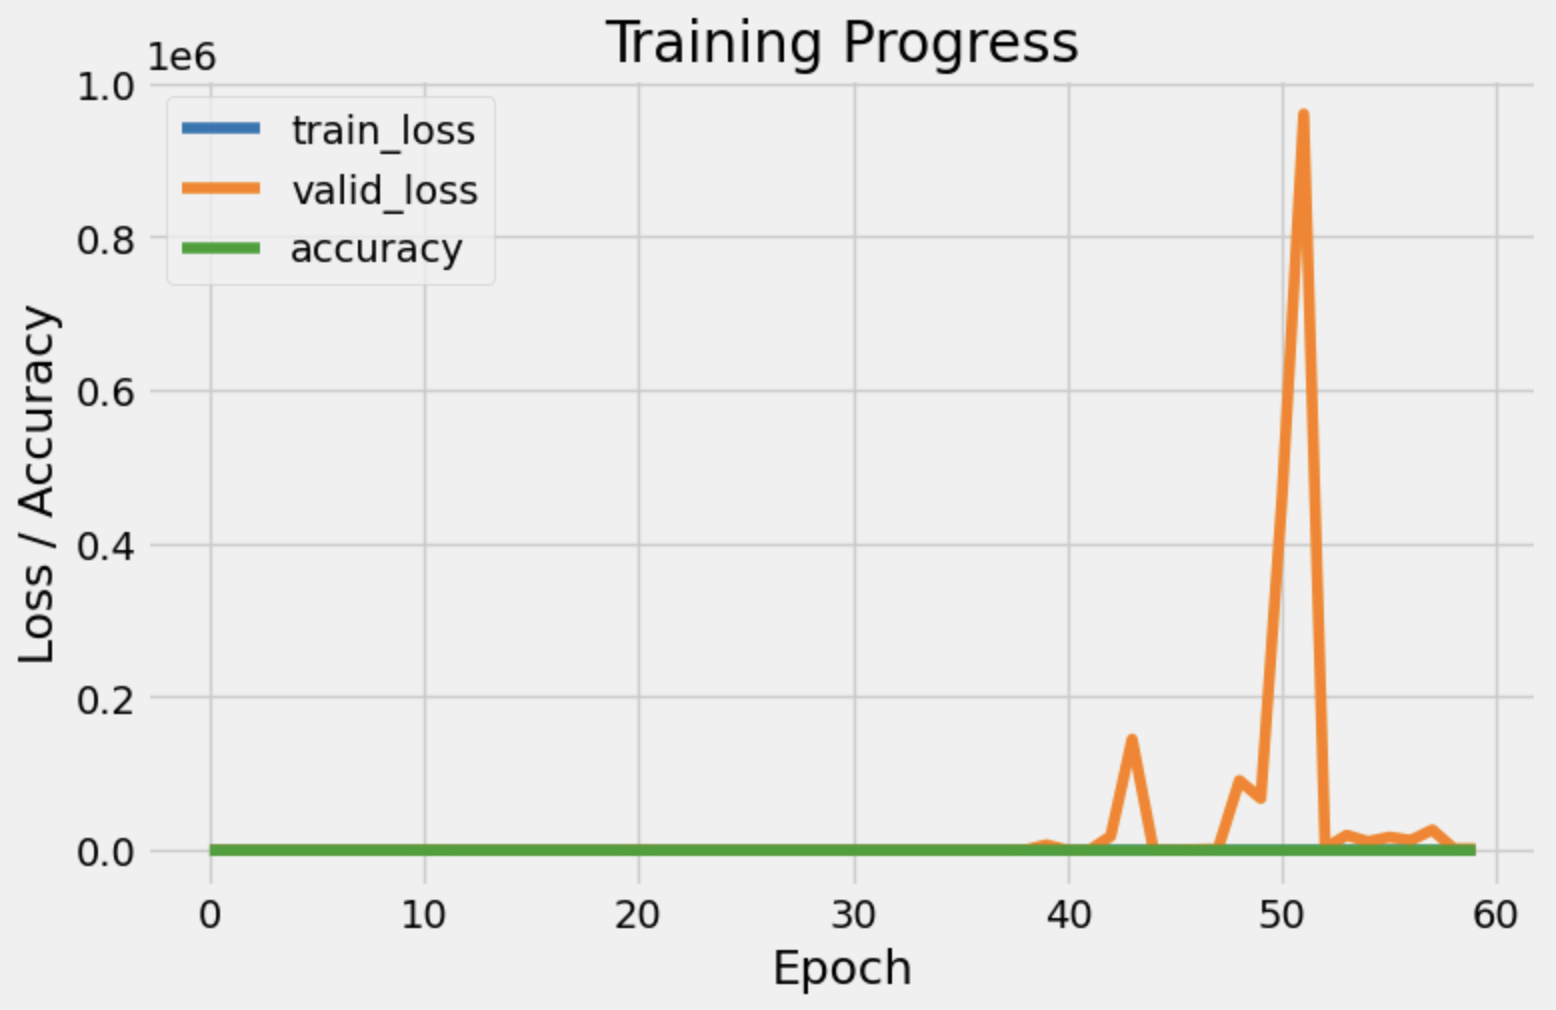

#### Batch Size Influence on Performance
Recall that I had to define batch size to two - i.e. bs=2 - in the fast.ai DataLoaders variable in order to allow the 1000 pixel-width and ResNet152 model to train. I tried bs=1 and fractional elements just to see how much range I could work with. Well, bs=2 seems to be the smallest possible value fast.ai will allow. So I got lucky that the 1000-ResNet152 combo just barely fit!

However, I did train several of our most promising combinations over a range of binary batch sizes from 2 to 64. [As I understand it](https://www.youtube.com/watch?v=Y-zswp6Yxf0), the batch size is the number of MoonBoard screenshots that are sent through the model before they update the model weights together. So bs=2 means that the data from two route screenshots are input into the model and the classification estimates for each are output. The training algorithm then compares these two sets of estimates vs. the actual labels and then tweaks the model weights to slightly better calculate the estimates next time. Then the process repeats with two new route screenshots and the new model weights!

Why might I care? 

Something allows the training to happen faster with *larger* batch sizes. Maybe this is simply from updating the model's weights less frequently per screenshot. Or maybe computers (especially with GPUs?) can handle multiple screenshots in parallel or there are other computer-per-screenshot savings somewhere else. 

That's an upside, but there can be at least one downside to larger batch sizes too: performance improvements per epoch decreases (and maybe overfits too?). For some reason, these bigger epochs are less efficient per picture at tuning the model toward lower training and validation loss and higher accuracy. I'm not entirely sure why. Maybe it's similar to compound interest or shortening the feedback loop. If each screenshot can make the model performance 1% better and we have 64 images, then updating the model once after all 64 images would improve performance 64%. If we update the model after each individual screenshot, this blossoms to 1.01^64 = 1.89, which is 89% improvement!

So how did we fare? Below shows training/validation losses and compared for batch sizes of 2, 4, 8, 16, 32, and 64. These were averaged across all combinations of 100 and 300 pixel widths, ResNet 18, 34, and 50, and epochs 1, 3, and 10 - except for the following combo, which needed more memory than what I could then get out of Google Colab: 64 batch size, 300 pixel, and ResNet50. 

As the batch size increases, the impressive drop in training loss is almost as stark as the divergence in training loss vs increasing (!) validation loss. One would obviously hope that both losses change together up or, preferably, down. When training loss improves at the cost of validation loss worsening, I'd guess that's a tell-tale sign of over-fitting. Why do large batch sizes cause more of this phenomenon? I'm not sure. Maybe there's something about fewer batches per epoch (i.e. large batch sizes) that tends to over-correct the weights. Maybe these larger batch sizes simply need more epochs to correct this!





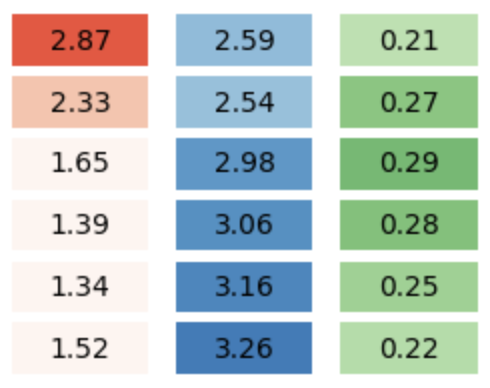

## Next Steps (Leaving Classification)

This first Fast.ai deep learning course starts with image classification, so I explored that model for this bouldering route evaluation. However, classification doesn't factor in that a route with difficulty '6A+' is next to '6B' and very far from '8B+'. So when a training screenshot is '6A+' but the model estimates '6B', the model corrects itself similarly as much as when the model incorrectly estimates '8B+'. Classification makes sense when inputs don't relate much to one another, but when there are strong relationships between the labels (e.g. difficulty levels), then this class paradigm seems sub-optimal. (However, it might be sufficient for our needs or maybe we could post-process the classification outputs - like weighted average of estimates and their probabilities - to yield something suitable!)

So if we leave classification, where do we go?

Well, I'm not sure. Linear algebra has logistic regression to estimate discrete outcomes, like classes, and **linear** regression to estimate continuous variables. I read that there's a regression model paradigm. Maybe that's better. Maybe there's even something else! I'll be keen to keep refining my knowledge, intuition and model options..

Until next time.

-John Mundahl


## Appendix ------------------------
### Final Training to Create Results



In [ ]:
from google.colab import drive
import os
import shutil

# Import fast.ai package
from fastai.vision.all import *

# Connect to your google drive where the moonboard pre-processed screen shots need to live according to pic_folder_paths
drive.mount('/content/gdrive')

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100"

### For Loop to Iterate the Model Parameters to see what seems best
## Goal Output: Three adjacent grids - each representing the three picture resolutions (x100, x300, x1000). 
#    Rows = Number of epochs (1, 3, 10, 30). 
#    Cols = Pretrained models (resent18, 34, 50, 101, 152)
#    Values = Max accuracy


# Define the paths to sets of pictures to try
pic_folder_paths = ["/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_100", 
                    "/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_300", 
                    "/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_1000"]

# Define the models to try
models_list = [models.resnet18, models.resnet34, models.resnet50, models.resnet101, models.resnet152]

# Define the number of epochs to try
num_epochs = [1, 3, 10, 30, 100]

# Create a variable to hold the output information
logger = [[[[0, 0, 0] for i in range(len(num_epochs))] 
           for j in range(len(models_list))] 
           for k in range(len(pic_folder_paths))]

# Define a function to extract the label from the filename
def label_func(fname):
    grade = str(fname).split("__")[-1].split(".")[0]
    return grade



# Define counters for the three loops
p_c = -1

# Iterate over all pictures
for p in pic_folder_paths:
  
  # Add to the p counter
  p_c += 1

  # Define the path to the folder containing the images
  path = Path(p)

  # Get a list of all image files in the folder
  files = get_image_files(path)

  # Create a DataLoaders object
  dls = ImageDataLoaders.from_name_func(path, files, valid_pct=0.2, seed=42, 
                                   bs=2, label_func=label_func)

  # Define counters for the three loops
  m_c = -1
  
  # Iterate over all models
  for m in models_list:

    # Add to the p counter
    m_c += 1
  
    # Define the model
    learn = vision_learner(dls, m, metrics=accuracy)

    # Define counters for the three loops
    n_c = -1
  
    # Iterate over all epoch values to try
    for n in num_epochs:

      # Add to the p counter
      n_c += 1
    
      # Fine Tune the Model
      learn.fine_tune(n)

      # Log the data resulting from the runs
      logger[p_c][m_c][n_c] = [learn.final_record[0], 
                               learn.final_record[1], 
                               learn.final_record[2]]
      
      # TEMPORARY: Print the logger
      print(logger)

# I ended up needing to run the code, wait for timeout or memory max-out.
# Then I'd save the logger values thus far, tweak pic_folder_paths, model_list, 
# and num_epochs to resume where it last was. So the final logger was stitched together.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


KeyboardInterrupt: ignored

In [ ]:
# ALL TOGETHER
logger = [[[[3.1721420288085938, 2.8418521881103516, 0.19230769574642181], [2.962719440460205, 2.7296314239501953, 0.21794871985912323], [2.540485382080078, 2.356175661087036, 0.19230769574642181], [2.294706344604492, 2.3031632900238037, 0.24358974397182465], [2.1938767433166504, 2.3333446979522705, 0.23076923191547394]], [[3.329214096069336, 2.866081714630127, 0.1666666716337204], [2.719484567642212, 2.302532434463501, 0.20512820780277252], [2.431589365005493, 2.3999037742614746, 0.24358974397182465], [2.3519113063812256, 2.501166582107544, 0.20512820780277252], [2.1620497703552246, 2.2720632553100586, 0.25641027092933655]], [[3.333441972732544, 3.1201915740966797, 0.14102564752101898], [2.8959550857543945, 2.5868752002716064, 0.21794871985912323], [2.4193077087402344, 2.3743040561676025, 0.24358974397182465], [2.3956148624420166, 2.3183553218841553, 0.24358974397182465], [2.182905435562134, 2.2676327228546143, 0.24358974397182465]], [[3.273902416229248, 3.280583381652832, 0.11538461595773697], [2.911172866821289, 2.424834728240967, 0.24358974397182465], [2.502211332321167, 2.560750722885132, 0.24358974397182465], [2.3169944286346436, 2.3198609352111816, 0.24358974397182465], [2.294267416000366, 2.5462496280670166, 0.23076923191547394]], [[3.4129080772399902, 3.092418670654297, 0.1666666716337204], [2.9590542316436768, 2.606597661972046, 0.28205129504203796], [2.6751632690429688, 2.6640963554382324, 0.25641027092933655], [2.344794511795044, 2.432467222213745, 0.24358974397182465], [2.2292656898498535, 2.466689348220825, 0.24358974397182465]]], [[[3.4961609840393066, 2.7221837043762207, 0.14102564752101898], [2.7567713260650635, 2.3711113929748535, 0.21794871985912323], [2.4729530811309814, 2.319035768508911, 0.21794871985912323], [2.235189199447632, 2.210129737854004, 0.24358974397182465], [2.1315057277679443, 2.199640989303589, 0.25641027092933655]], [[3.496595859527588, 2.4652607440948486, 0.24358974397182465], [2.940363883972168, 2.5254523754119873, 0.24358974397182465], [2.5573811531066895, 2.436190605163574, 0.25641027092933655], [2.4290125370025635, 2.308741569519043, 0.24358974397182465], [2.207961082458496, 2.323729991912842, 0.20512820780277252]], [[3.360869884490967, 2.7688748836517334, 0.20512820780277252], [2.6826834678649902, 2.5743424892425537, 0.23076923191547394], [2.436662435531616, 2.3288068771362305, 0.21794871985912323], [2.248591899871826, 2.268859386444092, 0.24358974397182465], [2.2915234565734863, 2.1983983516693115, 0.25641027092933655]], [[3.1408166885375977, 3.0578064918518066, 0.23076923191547394], [2.779433250427246, 2.3771562576293945, 0.23076923191547394], [2.563194751739502, 2.4696803092956543, 0.20512820780277252], [2.238574743270874, 2.3999226093292236, 0.24358974397182465], [2.1682822704315186, 2.2861216068267822, 0.24358974397182465]], [[2.966918706893921, 2.4968745708465576, 0.23076923191547394], [2.662684440612793, 2.1681416034698486, 0.29487180709838867], [2.282472610473633, 1.8998812437057495, 0.3205128312110901], [2.266170024871826, 2.2824997901916504, 0.25641027092933655], [2.136624574661255, 2.114166021347046, 0.3205128312110901]]], [[[2.9394240379333496, 4.757616996765137, 0.1666666716337204], [2.680938959121704, 4.0937819480896, 0.1538461595773697], [2.4048349857330322, 2.041473865509033, 0.3333333432674408], [2.252042531967163, 2.134768486022949, 0.3076923191547394], [2.097468376159668, 2.1181724071502686, 0.29487180709838867]], [[3.1395068168640137, 2.2052817344665527, 0.3205128312110901], [2.9148218631744385, 2.32482647895813, 0.29487180709838867], [2.5584330558776855, 2.271259307861328, 0.29487180709838867], [2.3446896076202393, 2.2377848625183105, 0.23076923191547394], [2.3446896076202393, 2.2377848625183105, 0.23076923191547394]], [[3.0897819995880127, 2.877624034881592, 0.24358974397182465], [2.795382499694824, 2.327827215194702, 0.21794871985912323], [2.5266971588134766, 2.3805181980133057, 0.23076923191547394], [2.323030948638916, 2.4140429496765137, 0.29487180709838867], [2.172686815261841, 2.245549440383911, 0.28205129504203796]], [[3.233285427093506, 2.3025286197662354, 0.26923078298568726], [2.8297884464263916, 2.373430013656616, 0.26923078298568726], [2.4442999362945557, 2.2853307723999023, 0.23076923191547394], [2.3120310306549072, 2.194239377975464, 0.28205129504203796], [2.102572441101074, 2.4508049488067627, 0.23076923191547394]], [[3.1146297454833984, 2.609217405319214, 0.24358974397182465], [2.9704763889312744, 2.5203003883361816, 0.25641027092933655], [2.550330638885498, 2.3941125869750977, 0.28205129504203796], [2.262942314147949, 2.1807398796081543, 0.28205129504203796], [2.0729362964630127, 1968.455078125, 0.03846153989434242]]]]


### Visualizing the Results

In [ ]:
## DEMO OUTPUT (val, test, and accuracy for 300, resent50, 10)
logger[1][2][2]

import matplotlib.pyplot as plt
import numpy as np

# Define the color maps for each box
red_cmap = plt.cm.get_cmap('Reds')
blue_cmap = plt.cm.get_cmap('Blues')
green_cmap = plt.cm.get_cmap('Greens')

# Define the numerical values for each box
left_val = logger[1][2][2][0]
center_val = logger[1][2][2][1]
right_val = logger[1][2][2][2]

# Define the color for each box based on its value
left_color = red_cmap((left_val-2)/1.5)
center_color = blue_cmap((center_val-1.5)/3.5)
right_color = green_cmap((right_val-0.1)/0.35)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 2), ncols=3)

# Draw the left box
ax[0].add_patch(plt.Rectangle((0, 0), 1, 1, color=left_color))
ax[0].text(0.5, 0.5, f'{left_val:.2f}', ha='center', va='center', color='black')

# Draw the center box
ax[1].add_patch(plt.Rectangle((0, 0), 1, 1, color=center_color))
ax[1].text(0.5, 0.5, f'{center_val:.2f}', ha='center', va='center', color='black')

# Draw the right box
ax[2].add_patch(plt.Rectangle((0, 0), 1, 1, color=right_color))
ax[2].text(0.5, 0.5, f'{right_val:.2f}', ha='center', va='center', color='black')

# Remove the ticks and axis labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis('off')

plt.show()




## COMPARE ACROSS NUMBER OF EPOCHS (300?, resnet50?, 1-100)
import matplotlib.pyplot as plt
import numpy as np

# Define the input data as a list of lists
input_list_of_lists = logger[1][2]

# Define a function that plots this tasteful chart
def tasteful_chart(input_list_of_lists):
  # Create the figure and axes
  fig, ax = plt.subplots(figsize=(3, (len(input_list_of_lists)+1)/3), nrows=len(input_list_of_lists), ncols=3)

  # Loop through each row of data
  for i, row in enumerate(input_list_of_lists):
      
      # Define the values that determine the shade of each box
      left_val = row[0]
      center_val = row[1]
      right_val = row[2]

      # Define the colors for each box
      left_color = red_cmap((left_val-2)/1.5)
      center_color = blue_cmap((center_val-1.5)/2.5)
      right_color = green_cmap((right_val-0.1)/0.35)

      # Draw the left box
      ax[i, 0].add_patch(plt.Rectangle((0, 0), 1, 1, color=left_color))
      ax[i, 0].text(0.5, 0.5, f'{left_val:.2f}', ha='center', va='center', color='black')

      # Draw the center box
      ax[i, 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=center_color))
      ax[i, 1].text(0.5, 0.5, f'{center_val:.2f}', ha='center', va='center', color='black')

      # Draw the right box
      ax[i, 2].add_patch(plt.Rectangle((0, 0), 1, 1, color=right_color))
      ax[i, 2].text(0.5, 0.5, f'{right_val:.2f}', ha='center', va='center', color='black')

      # Remove the ticks and axis labels
      for a in ax[i]:
          a.set_xticks([])
          a.set_yticks([])
          a.axis('off')

  plt.show()

tasteful_chart(input_list_of_lists)

## COMPARE ACROSS MODEL COMPLEXITY (300?, resenet18-152, 10?)
logger_complexity = [[0,0,0] for aa in range(5)]

for aa in range(5):
  logger_complexity[aa][:] = logger[1][aa][2]

tasteful_chart(logger_complexity)

## COMPARE ACROSS PHOTO RESOLUTION (100-1000, resent50?, 10?)
logger_complexity = [[0,0,0] for aa in range(3)]

for aa in range(3):
  logger_complexity[aa][:] = logger[aa][2][2]

tasteful_chart(logger_complexity)

In [ ]:
## COMPARE ACROSS NUMBER OF EPOCHS (ALL, ALL, 1-100)
logger_avg_epochs = [[0,0,0] for aa in range(5)]
for aa in range(len(logger)): # each resolution
  for bb in range(len(logger[0])): # each model
    for cc in range(len(logger[0][0])): # each epoch count
      for dd in range(len(logger[0][0][0])): # each result metric (3)
        logger_avg_epochs[cc][dd] += (1/15)*logger[aa][bb][cc][dd]

tasteful_chart(logger_avg_epochs)

## COMPARE ACROSS MODEL COMPLEXITY (ALL, resenet18-152, ALL)
logger_avg_models = [[0,0,0] for aa in range(5)]
for aa in range(len(logger)): # each resolution
  for bb in range(len(logger[0])): # each model
    for cc in range(len(logger[0][0])): # each epoch count
      for dd in range(len(logger[0][0][0])): # each result metric (3)
        logger_avg_models[bb][dd] += (1/15)*logger[aa][bb][cc][dd]

tasteful_chart(logger_avg_models)

## COMPARE ACROSS PHOTO RESOLUTION (100-1000, ALL, ALL)
logger_avg_pixels = [[0,0,0] for aa in range(3)]
for aa in range(len(logger)): # each resolution
  for bb in range(len(logger[0])): # each model
    for cc in range(len(logger[0][0])): # each epoch count
      for dd in range(len(logger[0][0][0])): # each result metric (3)
        logger_avg_pixels[aa][dd] += (1/25)*logger[aa][bb][cc][dd]

tasteful_chart(logger_avg_pixels)

In [ ]:
logger_avg_epochs = [[0,0,0] for aa in range(5)]
for aa in range(len(logger)): # each resolution
  for bb in range(len(logger[0])): # each model
    for cc in range(len(logger[0][0])): # each epoch count
      for dd in range(len(logger[0][0][0])): # each result metric (3)
        logger_avg_epochs[cc][dd] += (1/15)*logger[aa][bb][cc][dd]

logger_avg_epochs

In [ ]:
## Plotting Validation Loss Over Time for ?

data = [    ['epoch', 'train_loss', 'valid_loss', 'accuracy', 'time'],
    [0, 2.428068, 2.447826, 0.205128, '00:23'],
    [1, 2.437517, 2.703941, 0.192308, '00:23'],
    [2, 2.441769, 2.297837, 0.230769, '00:22'],
    [3, 2.353780, 2.342412, 0.217949, '00:23'],
    [4, 2.373964, 2.316313, 0.243590, '00:23'],
    [5, 2.313417, 2.297175, 0.230769, '00:22'],
    [6, 2.485040, 2.410212, 0.243590, '00:23'],
    [7, 2.380829, 3.283288, 0.269231, '00:23'],
    [8, 2.289862, 2.434563, 0.243590, '00:23'],
    [9, 2.421454, 2.276166, 0.166667, '00:23'],
    [10, 2.333966, 2.427332, 0.166667, '00:24'],
    [11, 2.432466, 2.354331, 0.217949, '00:23'],
    [12, 2.389941, 2.324143, 0.243590, '00:22'],
    [13, 2.361292, 2.203779, 0.179487, '00:24'],
    [14, 2.379072, 2.310433, 0.269231, '00:23'],
    [15, 2.448228, 2.398334, 0.230769, '00:22'],
    [16, 2.359981, 2.388338, 0.256410, '00:23'],
    [17, 2.361007, 8.424103, 0.128205, '00:24'],
    [18, 2.349027, 2.265660, 0.256410, '00:23'],
    [19, 2.494838, 2.467500, 0.230769, '00:23'],
    [20, 2.429698, 2.439121, 0.256410, '00:24'],
    [21, 2.381346, 2.336966, 0.217949, '00:24'],
    [22, 2.441514, 2.449358, 0.243590, '00:22'],
    [23, 2.581305, 2.337734, 0.243590, '00:24'],
    [24, 2.442912, 2.395737, 0.217949, '00:23'],
    [25, 2.421415, 2.266546, 0.217949, '00:23'],
    [26, 2.475284, 2.432415, 0.128205, '00:23'],
    [27, 2.407381, 2.427126, 0.217949, '00:24'],
    [28, 2.469677, 3.129333, 0.141026, '00:23'],
    [29, 2.544660, 3.882745, 0.217949, '00:23'],
    [30, 2.494965, 2.934974, 0.166667, '00:24'],
    [31, 2.394317, 2.296823, 0.243590, '00:24'],
    [32, 2.395235, 2.428947, 0.243590, '00:23'],
    [33, 2.447858, 3.869466, 0.179487, '00:24'],
    [34, 2.405635, 2.766745, 0.217949, '00:24'],
    [35, 2.404461, 2.399953, 0.243590, '00:23'],
    [36, 2.417002, 2.365609, 0.230769, '00:23'],
    [37, 2.462067, 2.392313, 0.243590, '00:24'],
    [38, 2.418872, 12.372146, 0.256410, '00:24'],
    [39, 2.451555, 2.659865, 0.217949, '00:23'],
    [40, 2.375854, 3.137277, 0.243590, '00:24'],
    [41, 2.435282, 2.636708, 0.243590, '00:24'],
    [42, 2.563181, 3.033961, 0.243590, '00:24'],
    [43, 2.390143, 2.990387, 0.128205, '00:23'],
    [44, 2.391930, 2.673389, 0.243590, '00:24'],
    [45, 2.376712, 4.366805, 0.179487, '00:24'],
    [46, 2.392483, 2.533030, 0.230769, '00:23'],
    [47, 2.381282, 2.593263, 0.230769, '00:24'],
    [48, 2.395456, 2.615051, 0.230769, '00:24'],
    [49, 2.399263, 3.128223, 0.256410, '00:24']
]

import matplotlib.pyplot as plt

# Extract the data from the nested list
epochs = [d[0] for d in data[1:]]
train_loss = [d[1] for d in data[1:]]
valid_loss = [d[2] for d in data[1:]]
accuracy = [d[3] for d in data[1:]]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.plot(epochs, train_loss, color='#1f77b4', label='train_loss')
ax.plot(epochs, valid_loss, color='#ff7f0e', label='valid_loss')
ax.plot(epochs, accuracy, color='#2ca02c', label='accuracy')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Training Progress')
ax.legend(loc='upper left')

# Set the style to mimic fivethirtyeight graphics
plt.style.use('fivethirtyeight')

# Show the plot
plt.show()

In [ ]:
data = [    ['epoch', 'train_loss', 'valid_loss', 'accuracy', 'time'],
    [0, 3.024192, 3.589874, 0.179487, '04:40'],
    [1, 3.013922, 4.411576, 0.243590, '04:39'],
    [2, 2.935521, 4.801393, 0.128205, '04:38'],
    [3, 3.336209, 15.689338, 0.282051, '04:38'],
    [4, 3.212492, 7.641412, 0.064103, '04:38'],
    [5, 2.977661, 45.685627, 0.051282, '04:38'],
    [6, 2.971216, 57.890266, 0.128205, '04:38'],
    [7, 2.787223, 19.390921, 0.282051, '04:38'],
    [8, 2.707469, 86.501564, 0.038462, '04:38'],
    [9, 3.157185, 13.374509, 0.217949, '04:38'],
    [10, 2.894220, 155.396103, 0.038462, '04:38'],
    [11, 2.842565, 122.204742, 0.282051, '04:37'],
    [12, 2.872415, 14.389450, 0.128205, '04:37'],
    [13, 2.685917, 3.080103, 0.282051, '04:37'],
    [14, 2.593213, 7.141236, 0.115385, '04:37'],
    [15, 2.842935, 3.316335, 0.141026, '04:35'],
    [16, 2.732253, 2.334579, 0.269231, '04:35'],
    [17, 2.567351, 3.206857, 0.269231, '04:36'],
    [18, 2.647827, 3.020525, 0.294872, '04:36'],
    [19, 2.732900, 2.548282, 0.282051, '04:35'],
    [20, 2.714150, 423.246399, 0.038462, '04:36'],
    [21, 2.647588, 2.399867, 0.269231, '04:35'],
    [22, 2.684308, 2.202811, 0.307692, '04:35'],
    [23, 2.648034, 2.489130, 0.269231, '04:35'],
    [24, 2.664115, 3.105430, 0.256410, '04:35'],
    [25, 2.556115, 2.641015, 0.217949, '04:34'],
    [26, 2.580160, 2.327986, 0.282051, '04:34'],
    [27, 2.606410, 3.006129, 0.282051, '04:34'],
    [28, 2.408694, 2.952913, 0.282051, '04:34'],
    [29, 2.445210, 2.421428, 0.256410, '04:34'],
    [30, 2.464860, 2.988929, 0.153846, '04:34'],
    [31, 2.414135, 2.406756, 0.256410, '04:34'],
    [32, 2.509594, 2.969793, 0.243590, '04:34'],
    [33, 2.450797, 2.177593, 0.282051, '04:34'],
    [34, 2.567027, 2.319909, 0.217949, '04:33'],
    [35, 2.408276, 2.220194, 0.205128, '04:33'],
    [36, 2.415719, 2.182924, 0.282051, '04:33'],
    [37, 2.371855, 3.451286, 0.128205, '04:34'],
    [38, 2.360186, 194.015656, 0.128205, '04:35'],
    [39, 2.400918, 7229.116211, 0.012821, '04:35'],
    [40, 2.406947, 91.128731, 0.051282, '04:35'],
    [41, 2.421581, 36.348618, 0.012821, '04:35'],
    [42, 2.267551, 18397.964844, 0.012821, '04:34'],
    [43, 2.197655, 144960.390625, 0.038462, '04:34'],
    [44, 2.27553, 248.478561, 0.051282, '04:34'],
    [45, 2.357865, 218.103973, 0.051282, '04:34'],
    [46, 2.146889, 1138.734253, 0.115385, '04:34'],
    [47, 2.355044, 1662.481812, 0.115385, '04:34'],
    [48, 2.143364, 91015.445312, 0.012821, '04:34'],
    [49, 2.201224, 67714.507812, 0.115385, '04:34'],
    [50, 2.210456, 464609.375, 0.012821, '04:34'],
    [51, 2.192432, 960324.625, 0.012821, '04:34'],
    [52, 2.194557, 2781.382324, 0.038462, '04:34'],
    [53, 2.095901, 19718.986328, 0.115385, '04:34'],
    [54, 2.086385, 11482.063477, 0.282051, '04:34'],
    [55, 2.131873, 17273.554688, 0.012821, '04:34'],
    [56, 2.061417, 13145.415039, 0.038462, '04:34'],
    [57, 2.030875, 26754.148438, 0.115385, '04:34'],
    [58, 2.112349, 2108.286377, 0.038462, '04:34'],
    [59, 2.072936, 1968.455078, 0.038462, '04:33']
]

import matplotlib.pyplot as plt

# Extract the data from the nested list
epochs = [d[0] for d in data[1:]]
train_loss = [d[1] for d in data[1:]]
valid_loss = [d[2] for d in data[1:]]
accuracy = [d[3] for d in data[1:]]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.plot(epochs, train_loss, color='#1f77b4', label='train_loss')
ax.plot(epochs, valid_loss, color='#ff7f0e', label='valid_loss')
ax.plot(epochs, accuracy, color='#2ca02c', label='accuracy')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Training Progress')
ax.legend(loc='upper left')

# Set the style to mimic fivethirtyeight graphics
plt.style.use('fivethirtyeight')

# Show the plot
plt.show()

In [ ]:
# Batch sizes, partial
logger_batches = [[[[[3.072760581970215, 2.685542583465576, 0.19230769574642181], [2.936077117919922, 2.4273228645324707, 0.23076923191547394], [2.446077346801758, 2.3230528831481934, 0.21794871985912323]], [[3.44695782661438, 2.8128702640533447, 0.1794871836900711], [3.091221332550049, 2.630988597869873, 0.20512820780277252], [2.5376291275024414, 2.342517375946045, 0.26923078298568726]], [[3.267784833908081, 3.13708758354187, 0.1666666716337204], [2.8044607639312744, 2.8379554748535156, 0.19230769574642181], [2.4081804752349854, 2.407184600830078, 0.24358974397182465]]], [[[2.9202044010162354, 2.8261663913726807, 0.23076923191547394], [2.4817702770233154, 2.677295684814453, 0.25641027092933655], [1.2930872440338135, 2.1857552528381348, 0.3076923191547394]], [[3.1726303100585938, 2.715298891067505, 0.23076923191547394], [2.6555564403533936, 2.290196657180786, 0.25641027092933655], [1.7129013538360596, 2.112417459487915, 0.3076923191547394]], [[3.3953707218170166, 3.436803102493286, 0.20512820780277252], [2.3290324211120605, 2.558558225631714, 0.26923078298568726], [1.2488070726394653, 2.3629555702209473, 0.28205129504203796]]], [[[2.8291239738464355, 2.5556983947753906, 0.24358974397182465], [1.544633150100708, 2.4635069370269775, 0.3205128312110901], [0.2754915654659271, 3.4042859077453613, 0.3461538553237915]], [[2.9968748092651367, 3.0168583393096924, 0.20512820780277252], [2.029552459716797, 2.6783697605133057, 0.28205129504203796], [0.379096120595932, 3.4220075607299805, 0.3076923191547394]], [[3.317269802093506, 3.7901244163513184, 0.19230769574642181], [1.6585909128189087, 2.526134729385376, 0.3205128312110901], [0.2636461555957794, 3.8960838317871094, 0.3461538553237915]]], [[[2.7182540893554688, 2.7594988346099854, 0.25641027092933655], [1.2064306735992432, 2.624070167541504, 0.3076923191547394], [0.23462140560150146, 3.095320224761963, 0.28205129504203796]], [[2.991669178009033, 2.8994858264923096, 0.20512820780277252], [1.3926647901535034, 2.7970542907714844, 0.3205128312110901], [0.34912484884262085, 3.819239616394043, 0.3333333432674408]], [[2.6953887939453125, 3.3817851543426514, 0.24358974397182465], [1.2092939615249634, 3.4585180282592773, 0.29487180709838867], [0.27366042137145996, 3.493583917617798, 0.29487180709838867]]], [[[3.0084259510040283, 2.6902353763580322, 0.1538461595773697], [1.0478254556655884, 2.4553000926971436, 0.28205129504203796], [0.18412688374519348, 3.1122965812683105, 0.29487180709838867]], [[2.8732426166534424, 3.152570962905884, 0.19230769574642181], [1.2730680704116821, 2.8170249462127686, 0.26923078298568726], [0.29049059748649597, 3.743168830871582, 0.25641027092933655]], [[2.1586620807647705, 3.2362239360809326, 0.25641027092933655], [0.7907645106315613, 3.6509881019592285, 0.25641027092933655], [0.2962212860584259, 4.504036903381348, 0.26923078298568726]]], [[[3.3324034214019775, 3.552617073059082, 0.05128205195069313], [1.517874002456665, 2.677616596221924, 0.24358974397182465], [0.2737129330635071, 2.8990488052368164, 0.3589743673801422]], [[3.2522568702697754, 3.183551788330078, 0.19230769574642181], [1.4849529266357422, 3.0202839374542236, 0.3076923191547394], [0.2788247764110565, 3.1960818767547607, 0.3205128312110901]], [[2.395165205001831, 3.066248655319214, 0.19230769574642181], [0.7362566590309143, 3.397212028503418, 0.21794871985912323], [0.17000870406627655, 4.571538925170898, 0.25641027092933655]]]], [[[[3.144230365753174, 2.6153035163879395, 0.21794871985912323], [2.8025481700897217, 2.5434250831604004, 0.19230769574642181], [2.527430772781372, 2.401616334915161, 0.23076923191547394]], [[3.255537748336792, 2.9353086948394775, 0.1538461595773697], [2.848128318786621, 2.433018922805786, 0.23076923191547394], [2.491353750228882, 2.352210521697998, 0.20512820780277252]], [[3.298532247543335, 2.471369743347168, 0.21794871985912323], [2.8618216514587402, 2.490067481994629, 0.1666666716337204], [2.505157232284546, 2.5594232082366943, 0.20512820780277252]]], [[[2.9694156646728516, 2.4908735752105713, 0.3589743673801422], [2.134253740310669, 2.4082376956939697, 0.26923078298568726], [1.2772693634033203, 2.592944383621216, 0.26923078298568726]], [[3.126084327697754, 2.6835010051727295, 0.24358974397182465], [2.5974605083465576, 2.3709113597869873, 0.3076923191547394], [1.707680344581604, 2.3155152797698975, 0.24358974397182465]], [[3.2167398929595947, 3.207205057144165, 0.23076923191547394], [2.2901716232299805, 2.4857945442199707, 0.24358974397182465], [1.1671686172485352, 2.292771100997925, 0.28205129504203796]]], [[[2.6020960807800293, 2.9019548892974854, 0.24358974397182465], [1.4818358421325684, 2.5243120193481445, 0.3333333432674408], [0.2870740592479706, 3.2199079990386963, 0.3076923191547394]], [[2.9626998901367188, 2.6356656551361084, 0.29487180709838867], [1.7915748357772827, 2.723759889602661, 0.28205129504203796], [0.3462080657482147, 2.929285764694214, 0.3589743673801422]], [[2.7417495250701904, 3.3285059928894043, 0.23076923191547394], [1.725355863571167, 2.5787980556488037, 0.24358974397182465], [0.24174632132053375, 3.3608996868133545, 0.3076923191547394]]], [[[2.362372875213623, 3.0525691509246826, 0.24358974397182465], [1.0109355449676514, 2.7911667823791504, 0.3076923191547394], [0.22678643465042114, 3.129711151123047, 0.29487180709838867]], [[2.549004554748535, 2.7493865489959717, 0.21794871985912323], [1.327233910560608, 2.5838797092437744, 0.28205129504203796], [0.3214302062988281, 3.204808235168457, 0.29487180709838867]], [[2.3797340393066406, 3.974397659301758, 0.23076923191547394], [1.319824457168579, 3.1425349712371826, 0.26923078298568726], [0.23922476172447205, 3.592642068862915, 0.23076923191547394]]], [[[2.6829001903533936, 3.37030291557312, 0.11538461595773697], [1.0028777122497559, 2.8402392864227295, 0.28205129504203796], [0.23177194595336914, 3.221560478210449, 0.26923078298568726]], [[2.7999746799468994, 2.972827196121216, 0.21794871985912323], [1.215680480003357, 2.771084785461426, 0.28205129504203796], [0.31120482087135315, 2.8468894958496094, 0.29487180709838867]], [[1.904671311378479, 3.6511926651000977, 0.08974359184503555], [0.8418056964874268, 3.455280065536499, 0.28205129504203796], [0.24770110845565796, 3.5618574619293213, 0.3205128312110901]]], [[[2.8502790927886963, 5.014952182769775, 0.03846153989434242], [1.2936303615570068, 2.946789264678955, 0.19230769574642181], [0.2992848753929138, 3.160658597946167, 0.29487180709838867]], [[3.0773303508758545, 2.968543529510498, 0.11538461595773697], [1.4831994771957397, 2.588593006134033, 0.23076923191547394], [0.3376365303993225, 2.7291157245635986, 0.28205129504203796]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]]]]]

## COMPARE ACROSS BATCH SIZES (2-64, ALL, ALL, ALL)
logger_avg_batches = [[0,0,0] for aa in range(6)]

# Create a variable to hold the output information
for aa in range(len(logger_batches)): # each resolution
  for bb in range(len(logger_batches[0])): # each batch size
    for cc in range(len(logger_batches[0][0])): # each model
      for dd in range(len(logger_batches[0][0][0])): # each epoch count
        for ee in range(len(logger_batches[0][0][0][0])): # each result metric (3)
          if not (aa == 1 and cc == 2):
            # if logger_batches[aa][bb][cc][dd][ee] != 0:
              # logger_avg_batches[bb][ee] += (1/15)*logger_batches[aa][bb][cc][dd][ee]
            logger_avg_batches[bb][ee] += (1/15)*logger_batches[aa][bb][cc][dd][ee]

tasteful_chart(logger_avg_batches)

### Training Scheme to Compare Batch Sizes

In [ ]:
# Adding batch size changes! 
### For Loop to Iterate the Model Parameters to see what seems best
## Goal Output: Three adjacent grids - each representing the two picture resolutions (x100, x300). 
#    Rows = Number of epochs (1, 3, 10). 
#    Cols = Pretrained models (resent18, 34, 50)
#    Values = Max accuracy
# Let's also keep all of the training data

# Import fast.ai package
from fastai.vision.all import *

# Define the paths to sets of pictures to try

pic_folder_paths = ["/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_100", 
                    "/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_300",]

# Define the models to try
models_list = [models.resnet18, models.resnet34, models.resnet50]

# Define the number of epochs to try
num_epochs = [1, 3, 10]

# Define the batch sizes to try
batch_sizes = [2, 4, 8, 16, 32, 64]

# Create a variable to hold the output information
logger = [[[[[0, 0, 0] for i in range(len(num_epochs))] 
           for j in range(len(models_list))] 
           for l in range(len(batch_sizes))]
           for k in range(len(pic_folder_paths))]

# Define a function to extract the label from the filename
def label_func(fname):
    grade = str(fname).split("__")[-1].split(".")[0]
    return grade





  

# Define counters for the three (now 4!) loops
p_c = -1

# Iterate over all pictures
for p in pic_folder_paths:
  
  # Add to the p counter
  p_c += 1

  # Define the path to the folder containing the images
  path = Path(p)

  # Get a list of all image files in the folder
  files = get_image_files(path)

  # Define counters for the three (now 4!) loops
  o_c = -1
  
  # Iterate over all batch sizes
  for o in batch_sizes:
  
    # Add to the o counter
    o_c += 1
  
    # Create a DataLoaders object
    dls = ImageDataLoaders.from_name_func(path, files, valid_pct=0.2, seed=42, 
                                          bs = o, label_func=label_func)

    # Define counters for the three loops
    m_c = -1
    
    # Iterate over all models
    for m in models_list:

      # Add to the p counter
      m_c += 1
    
      # Define the model
      learn = vision_learner(dls, m, metrics=accuracy)

      # Define counters for the three loops
      n_c = -1
    
      # Iterate over all epoch values to try
      for n in num_epochs:

        # Add to the p counter
        n_c += 1
      
        # Fine Tune the Model
        learn.fine_tune(n)

        # Log the data resulting from the runs
        logger[p_c][o_c][m_c][n_c] = [learn.final_record[0], 
                                learn.final_record[1], 
                                learn.final_record[2]]
        
        # TEMPORARY: Print the logger
        print(logger)

### Code used to train the model in Hugging Face

In [ ]:
# Train the model!

from fastai.vision.all import *

# Define the path to the folder containing the images
path = Path("/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/processed_100")

# Define a function to extract the label from the filename
def label_func(fname):
    grade = str(fname).split("__")[-1].split(".")[0]
    return grade

# Get a list of all image files in the folder
files = get_image_files(path)

# Create a DataLoaders object
dls = ImageDataLoaders.from_name_func(path, files, valid_pct=0.2, seed=42, bs=8, label_func=label_func)

learn = vision_learner(dls, models.resnet34, metrics=accuracy)
learn.fine_tune(10)
learn.path = Path("/content/gdrive/MyDrive/Colab Notebooks/Fast.ai/DL1/Lect2/Moonboard/")
learn.export()

To Do List

4.   Save the loose data somewhere and somehow in case I want to revisit. It's saved
5. Consider commiting to git
6. Consider sharing in some way(s)?

